## RNN books recommendation system with TPU training

Welcome to this notebook

We assume that there is an interaction between an item (book) if there is a rating on the BX-Book-Ratings.csv file. We don't take into account the rate the user gives to the book.

Note: "items" in this notebook will refer to books

You want to improve your knowledge in recommendation systems (and the possible application for ecommerce)? You can check it out this [Medium blog post](https://medium.com/decathlondevelopers/personalization-strategy-and-recommendation-systems-at-d%C3%A9cathlon-canada-d9cb3d37f675) from [Décathlon Canada](https://www.decathlon.ca/en/) (world's largest sporting good retailer)

Note2: this notebook is in progress, if you like it or you would like the analysis to be deeper, please upvote it!

# 1. Notebook setup

## Libraries importation and setup

In [1]:
# installation of keras self attention layer
!pip install keras-self-attention

import os
from collections import Counter
from random import choice
import time

import numpy as np
import pandas as pd
import requests

from IPython.display import Image

import keras
from keras_self_attention import SeqSelfAttention

import tensorflow as tf
from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K
from tensorflow.keras import models

from skopt import gp_minimize
from skopt.space import Real, Categorical, Integer
from skopt.plots import plot_convergence
from skopt.utils import use_named_args

  Created wheel for keras-self-attention: filename=keras_self_attention-0.47.0-py3-none-any.whl size=17289 sha256=4acede3f5dc9875304ae4d02934e2d3cf1b43e49c8305a99cf8b4931481225e9
  Stored in directory: /root/.cache/pip/wheels/8d/30/e9/99546260fabd5f3a6faf320c9ed14aae34169efc514dad5bda
Successfully built keras-self-attention
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [2]:
# Tensorflow version checking
print("Tensorflow version " + tf.__version__)

Tensorflow version 2.2.0


In [3]:
# Detect hardware, return appropriate distribution strategy
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection. No parameters necessary if TPU_NAME environment variable is set. On Kaggle this is always the case.
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy() # default distribution strategy in Tensorflow. Works on CPU and single GPU.

print("REPLICAS: ", strategy.num_replicas_in_sync)

Running on TPU  grpc://10.0.0.2:8470
REPLICAS:  8


In [4]:
# define some parameters

## size of the train set
train_percent_split = 0.9

# first hyperparameters of the RNN model
epochs = 1
dropout = 0
embedding_size = 128
hidden_size_lstm = 128
learning_rate = 0.00276
attention_width = 20
add_dense_layer = True
hidden_size_dense = 128

validation_split = 0.1
n_reco = 20
n_min_interactions = 20
max_length_seq = 20
nb_last_item = 20
max_users = 5000

# iterations number for optimization with scikit-optimize lib
n_random_starts = 2
n_calls = 15

# 2. Data importation

In [5]:
# paths definition
path = '/kaggle/input/bookcrossing-dataset/Book reviews/'
book_fp = os.path.join(path, 'BX-Books.csv')
user_fp = os.path.join(path, 'BX-Users.csv')
rating_fp = os.path.join(path, 'BX-Book-Ratings.csv')

In [6]:
# files reading
def read_file(fp):
    data = pd.read_csv(fp,
                       sep=';',
                       encoding='latin-1',
                       low_memory=False,
                       header=0,
                       error_bad_lines=False)
    return data
    
user_df = read_file(user_fp)
item_df = read_file(book_fp)
rating_df = read_file(rating_fp)

b'Skipping line 6452: expected 8 fields, saw 9\nSkipping line 43667: expected 8 fields, saw 10\nSkipping line 51751: expected 8 fields, saw 9\nSkipping line 92038: expected 8 fields, saw 9\nSkipping line 104319: expected 8 fields, saw 9\nSkipping line 121768: expected 8 fields, saw 9\nSkipping line 144058: expected 8 fields, saw 9\nSkipping line 150789: expected 8 fields, saw 9\nSkipping line 157128: expected 8 fields, saw 9\nSkipping line 180189: expected 8 fields, saw 9\nSkipping line 185738: expected 8 fields, saw 9\nSkipping line 209388: expected 8 fields, saw 9\nSkipping line 220626: expected 8 fields, saw 9\nSkipping line 227933: expected 8 fields, saw 11\nSkipping line 228957: expected 8 fields, saw 10\nSkipping line 245933: expected 8 fields, saw 9\nSkipping line 251296: expected 8 fields, saw 9\nSkipping line 259941: expected 8 fields, saw 9\nSkipping line 261529: expected 8 fields, saw 9\n'


Datasets inspection

In [7]:
print(user_df.shape)
print(user_df.head())

(278858, 3)
   User-ID                            Location   Age
0        1                  nyc, new york, usa   NaN
1        2           stockton, california, usa  18.0
2        3     moscow, yukon territory, russia   NaN
3        4           porto, v.n.gaia, portugal  17.0
4        5  farnborough, hants, united kingdom   NaN


In [8]:
print(item_df.shape)
print(item_df.head())

(271360, 8)
         ISBN                                         Book-Title  \
0  0195153448                                Classical Mythology   
1  0002005018                                       Clara Callan   
2  0060973129                               Decision in Normandy   
3  0374157065  Flu: The Story of the Great Influenza Pandemic...   
4  0393045218                             The Mummies of Urumchi   

            Book-Author Year-Of-Publication                   Publisher  \
0    Mark P. O. Morford                2002     Oxford University Press   
1  Richard Bruce Wright                2001       HarperFlamingo Canada   
2          Carlo D'Este                1991             HarperPerennial   
3      Gina Bari Kolata                1999        Farrar Straus Giroux   
4       E. J. W. Barber                1999  W. W. Norton &amp; Company   

                                         Image-URL-S  \
0  http://images.amazon.com/images/P/0195153448.0...   
1  http://images

In [9]:
print(rating_df.shape)
print(rating_df.head())

(1149780, 3)
   User-ID        ISBN  Book-Rating
0   276725  034545104X            0
1   276726  0155061224            5
2   276727  0446520802            0
3   276729  052165615X            3
4   276729  0521795028            6


Rows seem sorted by User-ID, let's shuffle the rows

In [10]:
rating_df = rating_df.sample(frac=1).reset_index(drop=True)

In [11]:
rating_df.isna().sum()

User-ID        0
ISBN           0
Book-Rating    0
dtype: int64

We don't have NA on rating_df! Good point.

# 3. Data preparation

Let's rename the columns for simplicity.

In [12]:
colname_mapping = {
    'ISBN': 'item',
    'User-ID': 'user',
    'Book-Rating': 'rating',
    'Book-Title': 'name',
    'Book-Author': 'author',
    'Image-URL-M': 'image',
    'Publisher': 'publisher',
    'Year-Of-Publication': 'year'
}
rating_df = rating_df.rename(columns=colname_mapping)
item_df = item_df.rename(columns=colname_mapping)
user_df = user_df.rename(columns=colname_mapping)

Tokenization: converting books and users "real" ids to integer for efficiency of manipulation

In [13]:
items = list(set(item_df.item.unique().tolist() + rating_df.item.unique().tolist()))
users = user_df.user.unique() 
print(f'number of unique items: {len(items)}\nnumber of unique users: {len(users)}')

number of unique items: 341765
number of unique users: 278858


In [14]:
rating_df = rating_df[rating_df.item.isin(items)]
item_df = item_df[item_df.item.isin(items)]
rating_df.shape, item_df.shape

((1149780, 3), (271360, 8))

There is a huge number of different books!

In [15]:
user_to_token = {user: int(token) for token, user in enumerate(users)}
token_to_item = {token: user for user, token in user_to_token.items()}
item_to_token = {item: int(token) for token, item in enumerate(items)}
token_to_item = {token: item for item, token in item_to_token.items()}

rating_df['user_id'] = rating_df['user'].map(user_to_token)
rating_df['item_id'] = rating_df['item'].map(item_to_token).dropna().astype(int)

item_df['item_id'] = item_df['item'].map(item_to_token)
user_df['user_id'] = user_df['user'].map(user_to_token)

In [16]:
#%%timeit
#diff = set(item_df.item_id).difference(set(rating_df.item_id))
#len(diff), diff

In [17]:
item_df.item_id.nunique(), rating_df.item_id.nunique()

(271360, 340556)

In [18]:
item_df.head()

,item,name,author,year,publisher,Image-URL-S,image,Image-URL-L,item_id
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,337081
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,268791
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...,127767
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...,294916
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...,322098


Defining functions to print books characteristics such as name, author, publisher, year of publication and display the cover image for vizualisation

In [19]:
def print_single_item_characteristics(item_id=None, item_df=item_df):
    if not item_id:
        item_id = choice(item_df.item_id)
    if item_id not in set(item_df.item_id):
        print(f'item_id {item_id} not in df')
        return None

    item_df = item_df[item_df['item_id'] == item_id]
    url = item_df.image.values[0]
    response = requests.get(url)

    print(f'item_id: {item_id}; '
          f'name: {item_df.name.values[0]}; '
          f'author: {item_df.author.values[0]} '
          f'publisher: {item_df.publisher.values[0]} '
          f'year: {item_df.year.values[0]}')
    return Image(url)

def print_items_characteristics(item_id_list):
    for item_id in item_id_list:
        display(print_single_item_characteristics(item_id=item_id))

In [20]:
n_rating_by_user = rating_df.user_id.value_counts()

In [21]:
n_rating_by_user.describe()

count    105283.000000
mean         10.920851
std          90.562825
min           1.000000
25%           1.000000
50%           1.000000
75%           4.000000
max       13602.000000
Name: user_id, dtype: float64

Let's display some popular books characteristics for testing

In [22]:
top3_item_id = list(rating_df.item_id.value_counts().index.values[:3])

In [23]:
top3_item_id

[9042, 120082, 247990]

item_id: 9042; name: Wild Animus; author: Rich Shapero publisher: Too Far year: 2004


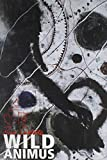

item_id: 120082; name: The Lovely Bones: A Novel; author: Alice Sebold publisher: Little, Brown year: 2002


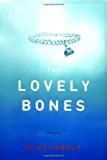

item_id: 247990; name: The Da Vinci Code; author: Dan Brown publisher: Doubleday year: 2003


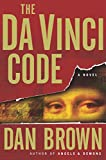

In [24]:
print_items_characteristics(item_id_list=top3_item_id)

Count the number of "interactions" per user (i.e. ratings per user)

In [25]:
user_occurence = Counter(rating_df.user).most_common()
print(user_occurence[:20])

[(11676, 13602), (198711, 7550), (153662, 6109), (98391, 5891), (35859, 5850), (212898, 4785), (278418, 4533), (76352, 3367), (110973, 3100), (235105, 3067), (230522, 2991), (16795, 2948), (234623, 2674), (36836, 2529), (52584, 2512), (245963, 2507), (204864, 2504), (55492, 2459), (185233, 2448), (171118, 2421)]


Keep users with at least n interactions, to reduce the data size and probably expect better "qualitative users"

In [26]:
def user_with_n_interaction(data, n):
    print(f'length before filtering: {len(data)}.')
    user_occurence = Counter(data.user)

    user_to_keep = [
        user
        for user, occ in user_occurence.items()
        if occ >= n
    ]

    data_filtered = data[data['user'].isin(user_to_keep)]
    print(f'length after filtering: {len(data_filtered)}.')
    return data_filtered

rating_df = user_with_n_interaction(data=rating_df, n=n_min_interactions)

length before filtering: 1149780.
length after filtering: 888884.


In [27]:
split_ind = int(len(rating_df) * train_percent_split)
train, test = rating_df[:split_ind], rating_df[split_ind:]
print(f'shape of train: {train.shape}\nshape of test: {test.shape}')

shape of train: (799995, 5)
shape of test: (88889, 5)


# 4. Sequences preparation for the RNN model

In [28]:
#function to prepare sequence data
def prepare_sequences(data, users, item_to_token, max_length=20, 
                      one_hot_encoding=False):
    
    print('preparing sequences')
    
    #generate sequences - see https://stackoverflow.com/questions/36864699/pandas-pivot-dataframe-with-unequal-columns        
    data = pd.concat([
        pd.DataFrame(
            {
                g:[0] * (max_length+1-len(d['item_id'].tolist()[-max_length-1:])) + d['item_id'].tolist()[-max_length-1:]
            }
        )
        for g,d in data.groupby('user_id')], axis=1)
 
    
    #from pandas dataframe to numpy array
    data = data.transpose().values
        
    #transpose and build the arrays
    x = np.array([i[:-1] for i in data])
    y = np.array([i[1:] for i in data])
            
    #build the one-hot encoding, if we want
    if one_hot_encoding:
        y = np_utils.to_categorical(y, len(item_to_token)+1)
    else:
        y = np.expand_dims(y, -1)
    
    print('sequences prepared')
        
    return (x, y)

#function to extract prediction from keras model at last timestep
def predict_last_timestep(model, data):
    #calculate the model output
    prediction = model.predict(data)
    #keep only the prediction at the final timestep
    return prediction[-1]

In [29]:
x, y = prepare_sequences(data=train, users=users, item_to_token=item_to_token, max_length=max_length_seq)

preparing sequences
sequences prepared


# 5. Keras model definition

In [30]:
def keras_model(hidden_size_lstm=hidden_size_lstm, 
                learning_rate=learning_rate, 
                dropout=dropout,
                attention_width=attention_width,
                embedding_size=embedding_size,
                add_dense_layer=add_dense_layer,
                hidden_size_dense=hidden_size_dense,
                embedding_matrix=None,
                item_to_token=item_to_token):
    
    with strategy.scope():
        embedding_layer = Embedding(len(item_to_token)+1,
                                    embedding_size,
                                    weights=embedding_matrix,
                                    mask_zero=True)

        model = Sequential()
        model.add(embedding_layer)
        model.add(LSTM(units=hidden_size_lstm,
                       activation='tanh', dropout=dropout,
                       return_sequences=True))
        model.add(SeqSelfAttention(attention_activation='sigmoid',
                                   attention_width=attention_width,
                                   history_only=True))
        if add_dense_layer:
            model.add(Dense(units=hidden_size_dense, activation='relu'))
        model.add(Dense(units=len(item_to_token)+1, activation='softmax'))
        optimizer = Adam(lr=learning_rate)
    # Compile model
    model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer,
                  metrics=['sparse_categorical_accuracy'])

    return model

# 6. Model training

In [31]:
#prepare the model
model = keras_model(hidden_size_lstm=hidden_size_lstm, 
                    learning_rate=learning_rate, 
                    dropout=dropout, 
                    embedding_size=embedding_size)  

history = model.fit(x, y,
                    epochs=epochs,
                    validation_split=validation_split,
                    batch_size=64,
                    verbose=1)

print(history.history['val_sparse_categorical_accuracy'][-1])


104/104 [==============================] - 26s 249ms/step - sparse_categorical_accuracy: 0.0019 - loss: 12.0682 - val_sparse_categorical_accuracy: 0.0022 - val_loss: 11.8146
0.0021709634456783533


# 7. Recommendations prediction

We make a list of users which are both present in train and test set. We will use these users to compute the performance metrics of our model.

In [32]:
common_user = list(set(train.user_id).intersection(test.user_id))
common_user[:10]

[32772, 262150, 163850, 196620, 98321, 32792, 131098, 229408, 32801, 163874]

In [33]:
print(f'There are {len(common_user)} common users between the train and test set')

There are 7173 common users between the train and test set


In [34]:
def reco_from_item_id_interacted(item_id_interacted, model=model, n_reco=10):
    predictions = predict_last_timestep(model=model,
                                        data=[item_id_interacted]).argsort()[0][:n_reco]
    return list(predictions)

def build_user_to_interacted(user_id, train=train):
    return train[train['user_id'] == user_id]['item_id'].dropna().unique().tolist()

#item_id_interacted = build_user_to_interacted(user_id=choice(user_train))
#len(item_id_interacted)

In [35]:
def user_to_last_visited_item_id_dict(train: pd.DataFrame,
                                      user_list: list,
                                      nb_last_item: int=None) -> dict:
    """
    Return a dictionary mapping user to last visited items id.
    input:
            :train: pd.DataFrame, training set
            :user_list: list, head_visitor_id
            :nb_last_item: int, number of last interacted items
                           to use to predict recommendation
    output:
            :: dict, mapping the user (head_visitor_id) to the last
               visited items
    """
    if nb_last_item:
        return train.groupby('user_id')['item_id'].apply(lambda g: g.values
                                                      .tolist()[-nb_last_item:]).to_dict()
    else:
        return train.groupby('user_id')['item_id'].apply(lambda g: g.values
                                                      .tolist()).to_dict()

user_to_last_visited_item_id_dict = user_to_last_visited_item_id_dict(train=train,
                                                                      user_list=train.user_id.unique().tolist(),
                                                                      nb_last_item=nb_last_item)

In [36]:
list(user_to_last_visited_item_id_dict.items())[:5]

[(182,
  [235757,
   268658,
   327568,
   221093,
   308464,
   229507,
   193093,
   262991,
   298148,
   320570,
   69270,
   336524,
   294902,
   168472,
   121636,
   176447,
   192618,
   197456,
   250762,
   26561]),
 (241,
  [168767,
   253685,
   243224,
   312043,
   20753,
   76091,
   218462,
   252810,
   244822,
   258808,
   135874,
   145802,
   336802,
   147551,
   58146,
   149140,
   211446,
   184101,
   228132,
   12224]),
 (242,
  [41207,
   195673,
   115620,
   171268,
   219769,
   164880,
   316411,
   81599,
   192721,
   45680,
   276102,
   157097,
   85409,
   329184,
   216278,
   291309,
   73602,
   115298,
   227303,
   2630]),
 (253,
  [96170,
   66014,
   86110,
   110631,
   274723,
   313491,
   108417,
   259531,
   301404,
   105332,
   54541,
   225971,
   288719,
   334933,
   257652,
   330983,
   292889,
   34055,
   207792,
   95301]),
 (382,
  [273055,
   150044,
   166229,
   255991,
   31286,
   149484,
   83077,
   296217,
   25414,


In [37]:
def predict_for_one(
    model,
    user_id,
    n_reco,
    user_to_last_visited_item_id_dict=user_to_last_visited_item_id_dict
):
    item_id_interacted = user_to_last_visited_item_id_dict[user_id]
    reco_id = reco_from_item_id_interacted(item_id_interacted,
                                           model=model,
                                           n_reco=n_reco)
    return reco_id

In [38]:
def predict(
    model,
    user_id_list,
    n_reco,
    user_to_last_visited_item_id_dict=user_to_last_visited_item_id_dict,
    max_users=None, # reduce computation time
):
    start = time.time()
    print(f'recommendation computation for {len(user_id_list[:max_users])} users.')
    print(f'n_reco={n_reco}')
    reco_dict = {
        user_id: predict_for_one(
            model=model,
            user_id=user_id,
            n_reco=n_reco,
            user_to_last_visited_item_id_dict=user_to_last_visited_item_id_dict
        )
        for user_id in user_id_list[:max_users]
    }
    print(f'predict for {len(user_id_list[:max_users])} spent {round(time.time()-start, 2)} s.')
    return reco_dict
#max_users=100
#n_reco=50
reco_dict = predict(
    model=model,
    user_id_list=common_user,
    user_to_last_visited_item_id_dict=user_to_last_visited_item_id_dict,
    max_users=max_users,
    n_reco=n_reco)

recommendation computation for 5000 users.
n_reco=20
predict for 5000 spent 7437.96 s.


In [39]:
list(reco_dict.items())[:3]

[(32772,
  [260757,
   119037,
   44061,
   281872,
   73734,
   268697,
   203668,
   107511,
   319145,
   5011,
   49592,
   258912,
   93350,
   217133,
   188079,
   56511,
   283411,
   184625,
   66618,
   335883]),
 (262150,
  [203668,
   188079,
   260757,
   119037,
   44061,
   268697,
   281872,
   56511,
   283411,
   49592,
   73734,
   157866,
   66618,
   157504,
   5011,
   12654,
   335883,
   14022,
   184625,
   319145]),
 (163850,
  [260757,
   119037,
   44061,
   281872,
   73734,
   217133,
   107511,
   319145,
   268697,
   5011,
   258912,
   93350,
   49592,
   211876,
   243858,
   184625,
   17885,
   335883,
   56511,
   66618])]

# 8. Performance metrics computation

In [40]:
#Function to calculate, precision, recall and coverage
def statistics_at_k(reco_dict,
                    test_df,
                    train_df,
                    calculate_precision=True,
                    calculate_recall=True, 
                    calculate_coverage=True): 
    '''
    reco_dict: dictionary with the uid as key, list of items recommended as attribute
    test_df: dataframe of user-item interactions
    '''     
    #calculate precision
    if calculate_precision:
        k_relevant = 0
        k_total = 0
        for uid, iid in reco_dict.items():
            iid_test = set(test_df[test_df['user_id'] == uid]['item_id'])
            for j in iid:
                k_total += 1
                if j in iid_test:
                    k_relevant += 1
        if not k_total:
            precision = 0
        else:
            precision = k_relevant/k_total
        print(f'precision={precision}')    
    else:
        precision = None
        
    #calculate precision
    if calculate_recall:
        k_relevant = 0
        k_total = 0
        for uid, iid in reco_dict.items():
            for j in list(test_df[test_df['user_id'] == uid]['item_id']):
                k_total += 1
                if j in set(iid):
                    k_relevant += 1
        
        if not k_total:
            recall = 0
        else:
            recall = k_relevant/k_total
        print(f'recall={recall}')
    else:
        recall = None
        
    #calculate coverage
    if calculate_coverage:
        nb_recommended = len(set(sum(reco_dict.values(), [])))
        nb_total = len(train_df['item_id'].unique())
        coverage = nb_recommended/nb_total
        print(f'coverage={coverage}')
    else:
        coverage = None
    
    return precision, recall, coverage

In [41]:
# statistics with RNN recommendation
statistics_at_k(reco_dict=reco_dict,
                test_df=test,
                train_df=train,
                calculate_precision=True,
                calculate_recall=True, 
                calculate_coverage=True)

precision=1e-05
recall=1.611291933872579e-05
coverage=0.000310649806300709


(1e-05, 1.611291933872579e-05, 0.000310649806300709)

In [42]:
topn = list(train.item_id.value_counts().index.values[:n_reco])
topn

[9042,
 120082,
 247990,
 285552,
 325639,
 123735,
 149484,
 66014,
 15398,
 311879,
 249318,
 212295,
 243036,
 168549,
 258430,
 157097,
 159057,
 172364,
 90496,
 89098]

In [43]:
reco_topn_dict = {
    user_id: topn
    for user_id in reco_dict.keys() 
}

In [44]:
list(reco_topn_dict.items())[:3]

[(32772,
  [9042,
   120082,
   247990,
   285552,
   325639,
   123735,
   149484,
   66014,
   15398,
   311879,
   249318,
   212295,
   243036,
   168549,
   258430,
   157097,
   159057,
   172364,
   90496,
   89098]),
 (262150,
  [9042,
   120082,
   247990,
   285552,
   325639,
   123735,
   149484,
   66014,
   15398,
   311879,
   249318,
   212295,
   243036,
   168549,
   258430,
   157097,
   159057,
   172364,
   90496,
   89098]),
 (163850,
  [9042,
   120082,
   247990,
   285552,
   325639,
   123735,
   149484,
   66014,
   15398,
   311879,
   249318,
   212295,
   243036,
   168549,
   258430,
   157097,
   159057,
   172364,
   90496,
   89098])]

In [45]:
# statistics with top n recommendation
statistics_at_k(reco_dict=reco_topn_dict,
                test_df=test,
                train_df=train,
                calculate_precision=True,
                calculate_recall=True, 
                calculate_coverage=True)

precision=0.00651
recall=0.01048951048951049
coverage=7.309407207075506e-05


(0.00651, 0.01048951048951049, 7.309407207075506e-05)

# 9. Visualization example

In [46]:
item_id_interacted = [197383]
item_id_pred = predict_last_timestep(
    model=model,data=[item_id_interacted]
).argsort()[0][:20]

In [47]:
# past interactions
item_df[item_df['item_id'].isin(item_id_interacted)]

,item,name,author,year,publisher,Image-URL-S,image,Image-URL-L,item_id
40684,0517703939,Dinosaur in a Haystack: Reflections in Natural...,Stephen Jay Gould,1996,Harmony Books,http://images.amazon.com/images/P/0517703939.0...,http://images.amazon.com/images/P/0517703939.0...,http://images.amazon.com/images/P/0517703939.0...,197383


item_id: 197383; name: Dinosaur in a Haystack: Reflections in Natural History; author: Stephen Jay Gould publisher: Harmony Books year: 1996


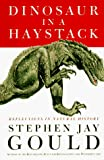

In [48]:
# visualization of the pas
print_items_characteristics(item_id_list=item_id_interacted)

In [49]:
# predictions
item_df[item_df['item_id'].isin(item_id_pred)]

,item,name,author,year,publisher,Image-URL-S,image,Image-URL-L,item_id
1758,157566559X,The Biograph Girl,William J. Mann,2000,Kensington Publishing Corp.,http://images.amazon.com/images/P/157566559X.0...,http://images.amazon.com/images/P/157566559X.0...,http://images.amazon.com/images/P/157566559X.0...,93350
19557,0801855578,The Friday Book: Essays and Other Nonfiction (...,John Barth,1997,Johns Hopkins University Press,http://images.amazon.com/images/P/0801855578.0...,http://images.amazon.com/images/P/0801855578.0...,http://images.amazon.com/images/P/0801855578.0...,281872
47133,037331194X,"Sweet Sacrifice (Harlequin Regency Romance, No...",Elizabeth Bailey,1993,Harlequin,http://images.amazon.com/images/P/037331194X.0...,http://images.amazon.com/images/P/037331194X.0...,http://images.amazon.com/images/P/037331194X.0...,119037
72967,0671015354,Hunter,James Byron Huggins,1999,Pocket,http://images.amazon.com/images/P/0671015354.0...,http://images.amazon.com/images/P/0671015354.0...,http://images.amazon.com/images/P/0671015354.0...,335883
86092,0192839691,The Mark on the Wall and Other Short Fiction (...,Virginia Woolf,2001,Oxford University Press,http://images.amazon.com/images/P/0192839691.0...,http://images.amazon.com/images/P/0192839691.0...,http://images.amazon.com/images/P/0192839691.0...,188079
108084,0697085775,Finite Mathematics,Howard L. Rolf,1991,William C. Brown,http://images.amazon.com/images/P/0697085775.0...,http://images.amazon.com/images/P/0697085775.0...,http://images.amazon.com/images/P/0697085775.0...,184625
120608,0373711174,Hidden Treasures,Judith Arnold,2003,Harlequin,http://images.amazon.com/images/P/0373711174.0...,http://images.amazon.com/images/P/0373711174.0...,http://images.amazon.com/images/P/0373711174.0...,66618
132542,0573606064,Skywalking: The Life and Films of George Lucas,Dale. Pollock,1990,Samuel French,http://images.amazon.com/images/P/0573606064.0...,http://images.amazon.com/images/P/0573606064.0...,http://images.amazon.com/images/P/0573606064.0...,283411
134218,0553378597,The Orchard: A Memoir,Adele Crockett Robertson,1997,Bantam,http://images.amazon.com/images/P/0553378597.0...,http://images.amazon.com/images/P/0553378597.0...,http://images.amazon.com/images/P/0553378597.0...,157504
141955,0300070853,"Marihuana, the Forbidden Medicine",Lester Grinspoon,1997,Yale University Press,http://images.amazon.com/images/P/0300070853.0...,http://images.amazon.com/images/P/0300070853.0...,http://images.amazon.com/images/P/0300070853.0...,157866


In [50]:
item_id_pred

array([260757, 203668, 119037,  44061, 281872, 188079, 268697,  73734,
        49592, 283411,   5011,  56511, 335883,  66618, 157504, 184625,
       319145, 107511,  93350, 157866])

item_id: 260757; name: Organon of the Medical Art; author: Samuel Hahnemann publisher: Birdcage Books year: 2000


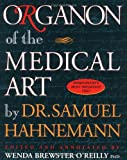

item_id 203668 not in df


None

item_id: 119037; name: Sweet Sacrifice (Harlequin Regency Romance, No 31194); author: Elizabeth Bailey publisher: Harlequin year: 1993


item_id 44061 not in df


None

item_id: 281872; name: The Friday Book: Essays and Other Nonfiction (Maryland Paperback Bookshelf); author: John Barth publisher: Johns Hopkins University Press year: 1997


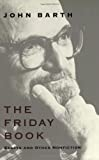

item_id: 188079; name: The Mark on the Wall and Other Short Fiction (Oxford World's Classics); author: Virginia Woolf publisher: Oxford University Press year: 2001


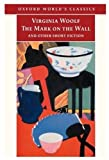

item_id 268697 not in df


None

item_id: 73734; name: Raker, No. 2: Tijuana Traffic (Raker); author: Don Scott publisher: Pinnacle Books year: 1982


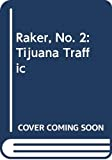

item_id 49592 not in df


None

item_id: 283411; name: Skywalking: The Life and Films of George Lucas; author: Dale. Pollock publisher: Samuel French year: 1990


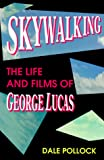

item_id 5011 not in df


None

item_id: 56511; name: How to Read Hands; author: Lori Reid publisher: Harpercollins year: 1985


item_id: 335883; name: Hunter; author: James Byron Huggins publisher: Pocket year: 1999


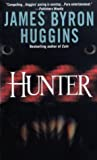

item_id: 66618; name: Hidden Treasures; author: Judith Arnold publisher: Harlequin year: 2003


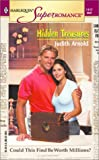

item_id: 157504; name: The Orchard: A Memoir; author: Adele Crockett Robertson publisher: Bantam year: 1997


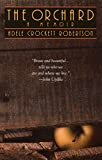

item_id: 184625; name: Finite Mathematics; author: Howard L. Rolf publisher: William C. Brown year: 1991


item_id 319145 not in df


None

item_id: 107511; name: The Human Country: New and Collected Stories (American Literature (Dalkey Archive)); author: Harry Mathews publisher: Dalkey Archive Press year: 2002


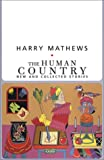

item_id: 93350; name: The Biograph Girl; author: William J. Mann publisher: Kensington Publishing Corp. year: 2000


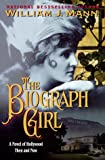

item_id: 157866; name: Marihuana, the Forbidden Medicine; author: Lester Grinspoon publisher: Yale University Press year: 1997


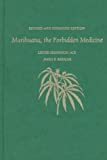

In [51]:
print_items_characteristics(item_id_list=item_id_pred)

In [52]:
del history
del model

# 10. RNN model hyperparameters optimization

In [53]:
# define the dimension to search
dim_epochs = Integer(low=1, high=15, name='epochs')
dim_hidden_size_lstm = Categorical(categories=[32, 64, 128, 256], name='hidden_size_lstm')
dim_learning_rate = Real(low=1e-4, high=5e-1, prior='log-uniform',
                         name='learning_rate')
dim_attention_width = Integer(low=1, high=50, name='attention_width')
dim_dropout = Real(low=0, high=0.9, name='dropout')
dim_embedding_size = Categorical(categories=[64, 128, 256, 512], name='embedding_size')
dim_add_dense_layer = Categorical(categories=[True, False], name='add_dense_layer')
dim_hidden_size_dense = Categorical(categories=[32, 64, 128, 256], name='hidden_size_dense')

dimensions = [dim_epochs,
              dim_hidden_size_lstm,
              dim_learning_rate,
              dim_attention_width,
              dim_dropout,
              dim_embedding_size,
              dim_add_dense_layer,
              dim_hidden_size_dense]

epochs = 3
dropout = 0
embedding_size = 256
hidden_size_lstm = 64
learning_rate = 0.00276

In [54]:
def optimize(dimensions=dimensions, n_calls=15, n_random_starts=3, verbose=1, x0=None):
    print(dimensions)
    @use_named_args(dimensions=dimensions)
    def fitness(**params):
        print(f'params={params}')
        model = keras_model(hidden_size_lstm=params['hidden_size_lstm'],
                            learning_rate=params['learning_rate'],
                            attention_width=params['attention_width'],
                            dropout=params['dropout'],
                            embedding_size=params['embedding_size'],
                            add_dense_layer=params['add_dense_layer'],
                            hidden_size_dense=params['hidden_size_dense'])  

        history = model.fit(x, y,
                            epochs=params['epochs'],
                            validation_split=validation_split,
                            batch_size=64,
                            verbose=verbose)
        sca = history.history['val_sparse_categorical_accuracy'][-1]
        print(f'##sca={sca}## with params={params}')
        del history
        del model
        return -1.0 * sca
    
    res = gp_minimize(func=fitness,
                      dimensions=dimensions,
                      acq_func='EI', # Expected Improvement.
                      n_calls=n_calls,
                      n_random_starts=n_random_starts,
                      x0=x0)
    print(f'best accuracy={-1.0 * res.fun} with {res.x}')
    return res

In [55]:
res = optimize(dimensions=dimensions,
               n_calls=n_calls,
               n_random_starts=n_random_starts,
               x0=[3, 256, 0.001, 40, 0, 512, True, 128])

[Integer(low=1, high=15, prior='uniform', transform='identity'), Categorical(categories=(32, 64, 128, 256), prior=None), Real(low=0.0001, high=0.5, prior='log-uniform', transform='identity'), Integer(low=1, high=50, prior='uniform', transform='identity'), Real(low=0, high=0.9, prior='uniform', transform='identity'), Categorical(categories=(64, 128, 256, 512), prior=None), Categorical(categories=(True, False), prior=None), Categorical(categories=(32, 64, 128, 256), prior=None)]
params={'epochs': 3, 'hidden_size_lstm': 256, 'learning_rate': 0.001, 'attention_width': 40, 'dropout': 0, 'embedding_size': 512, 'add_dense_layer': True, 'hidden_size_dense': 128}
Epoch 1/3


/opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/indexed_slices.py:431: UserWarning: Converting sparse IndexedSlices to a dense Tensor with 174984192 elements. This may consume a large amount of memory.
  num_elements)


104/104 [==============================] - 29s 283ms/step - sparse_categorical_accuracy: 0.0017 - loss: 12.1619 - val_sparse_categorical_accuracy: 0.0019 - val_loss: 11.8916
Epoch 2/3
104/104 [==============================] - 7s 70ms/step - sparse_categorical_accuracy: 0.0025 - loss: 11.0636 - val_sparse_categorical_accuracy: 0.0022 - val_loss: 12.1585
Epoch 3/3
104/104 [==============================] - 7s 71ms/step - sparse_categorical_accuracy: 0.0026 - loss: 10.7443 - val_sparse_categorical_accuracy: 0.0022 - val_loss: 12.3583
##sca=0.002238806104287505## with params={'epochs': 3, 'hidden_size_lstm': 256, 'learning_rate': 0.001, 'attention_width': 40, 'dropout': 0, 'embedding_size': 512, 'add_dense_layer': True, 'hidden_size_dense': 128}
params={'epochs': 4, 'hidden_size_lstm': 256, 'learning_rate': 0.00020841236213634833, 'attention_width': 4, 'dropout': 0.47914401001992796, 'embedding_size': 256, 'add_dense_layer': False, 'hidden_size_dense': 64}
Epoch 1/4
104/104 [=============

ValueError: array must not contain infs or NaNs

In [56]:
res

NameError: name 'res' is not defined

In [57]:
y

array([[[235757],
        [268658],
        [327568],
        ...,
        [197456],
        [250762],
        [ 26561]],

       [[168767],
        [253685],
        [243224],
        ...,
        [184101],
        [228132],
        [ 12224]],

       [[ 41207],
        [195673],
        [115620],
        ...,
        [115298],
        [227303],
        [  2630]],

       ...,

       [[     0],
        [     0],
        [ 47647],
        ...,
        [322174],
        [ 59225],
        [321414]],

       [[264379],
        [285427],
        [169566],
        ...,
        [151220],
        [ 93843],
        [144544]],

       [[171520],
        [255534],
        [181980],
        ...,
        [257122],
        [302710],
        [ 99511]]])

In [58]:
x

array([[278690, 235757, 268658, ..., 192618, 197456, 250762],
       [128608, 168767, 253685, ..., 211446, 184101, 228132],
       [176634,  41207, 195673, ...,  73602, 115298, 227303],
       ...,
       [     0,      0,      0, ..., 299624, 322174,  59225],
       [ 12133, 264379, 285427, ...,  77638, 151220,  93843],
       [  3972, 171520, 255534, ...,  67025, 257122, 302710]])